In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import mplfinance as mpf
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import pandas as pd

from tqdm import tqdm

,Open,High,Low,Close,Volume
Date,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,531500
...,...,...,...,...,...
2024-06-03,529.020020,529.309998,522.599976,527.799988,46835700
2024-06-04,526.460022,529.150024,524.960022,528.390015,34632700
2024-06-05,530.770020,534.690002,528.729980,534.669983,47610400


/Users/hetpatel/Documents/Python Projects/AI/StockBot/venv/lib/python3.12/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


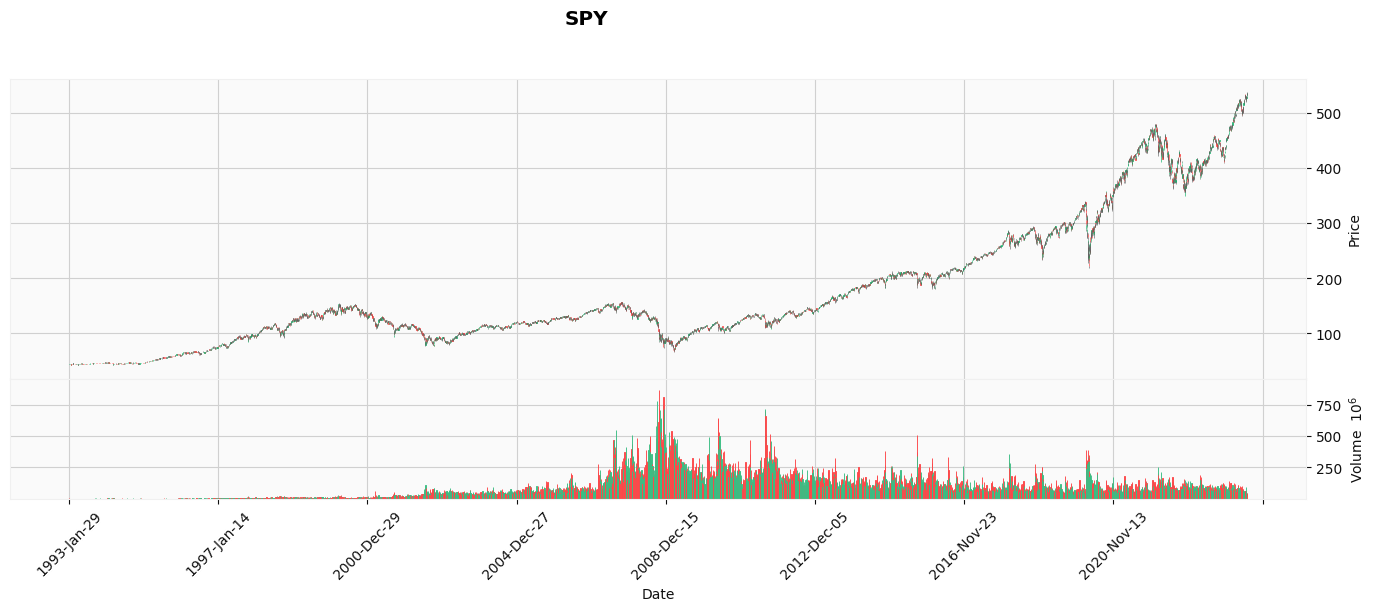

In [2]:
from IPython.display import display
SPY = pd.read_csv('SPY.csv', parse_dates=['Date'], index_col='Date')
SPY.drop(columns=['Adj Close'], inplace=True)
display(SPY)

mpf.plot(
    SPY,
    title="SPY",
    xlabel="Date",
    type="candle",
    volume=True,
    figsize=(18, 6),
    style="yahoo",
)

In [3]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(SPY[['Close']].values)
scaled_data

array([[0.00108139],
       [0.00171751],
       [0.00190834],
       ...,
       [1.        ],
       [0.99997962],
       [0.99865658]])

In [4]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 60  # for example, use last 60 days' data to predict the next day
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)

X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = scaler.inverse_transform(y_test)

print(f"{X_train.shape=}")
print(f"{y_train.shape=}")
print(f"{X_test.shape=}")
print(f"{y_test.shape=}")

X_train.shape=torch.Size([6268, 60, 1])
y_train.shape=torch.Size([6268, 1])
X_test.shape=torch.Size([1568, 60, 1])
y_test.shape=(1568, 1)


In [6]:
class LSTMNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMNetwork, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [7]:
# Hyperparameters
input_size = 1
hidden_size = 50
num_layers = 2
output_size = 1

model = LSTMNetwork(
    input_size=input_size,
    hidden_size=hidden_size,
    num_layers=num_layers,
    output_size=output_size,
)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [8]:
summary(
    model,
    input_size=(1, 60, 1),
    col_names=["input_size", "output_size", "num_params"],
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMNetwork                              [1, 60, 1]                [1, 1]                    --
├─LSTM: 1-1                              [1, 60, 1]                [1, 60, 50]               31,000
├─Linear: 1-2                            [1, 50]                   [1, 1]                    51
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.86
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.12
Estimated Total Size (MB): 0.15

100%|██████████| 100/100 [03:26<00:00,  2.06s/it, Loss: 2.4418441171292216e-05]


Total Epochs: 100


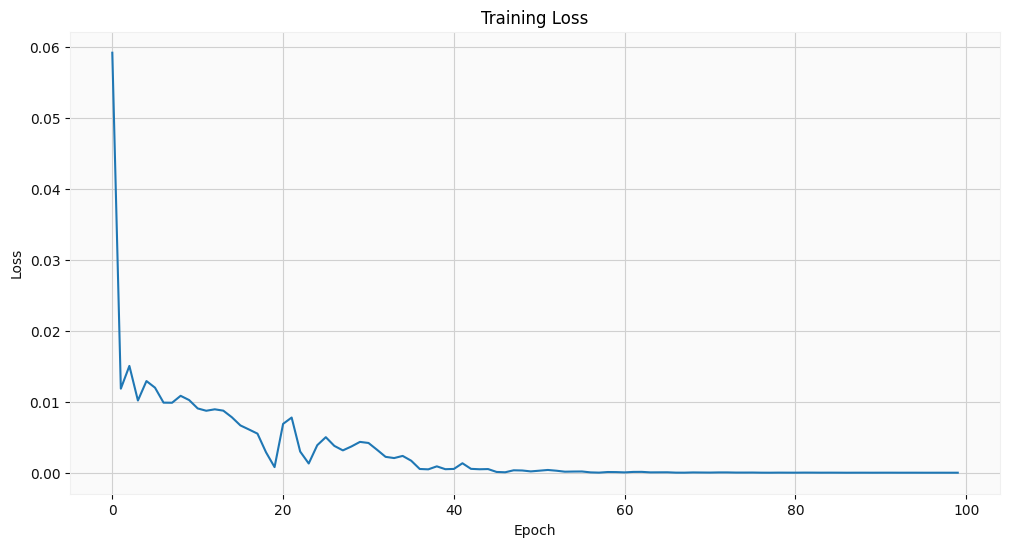

In [9]:
reset = True
if reset:
    loss_line = []

epochs = 100
for epoch in (pbar := tqdm(range(epochs))):
    model.train()
    outputs = model(X_train)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train)
    pbar.set_postfix_str(f"Loss: {loss.item()}")
    loss_line.append(loss.item())
    loss.backward()
    optimizer.step()

print(f"Total Epochs: {len(loss_line)}")
plt.figure(figsize=(12, 6))
plt.plot(loss_line)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

In [10]:
model.eval()
with torch.no_grad():
    y_test_pred = model(X_test)

y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())

397.2855


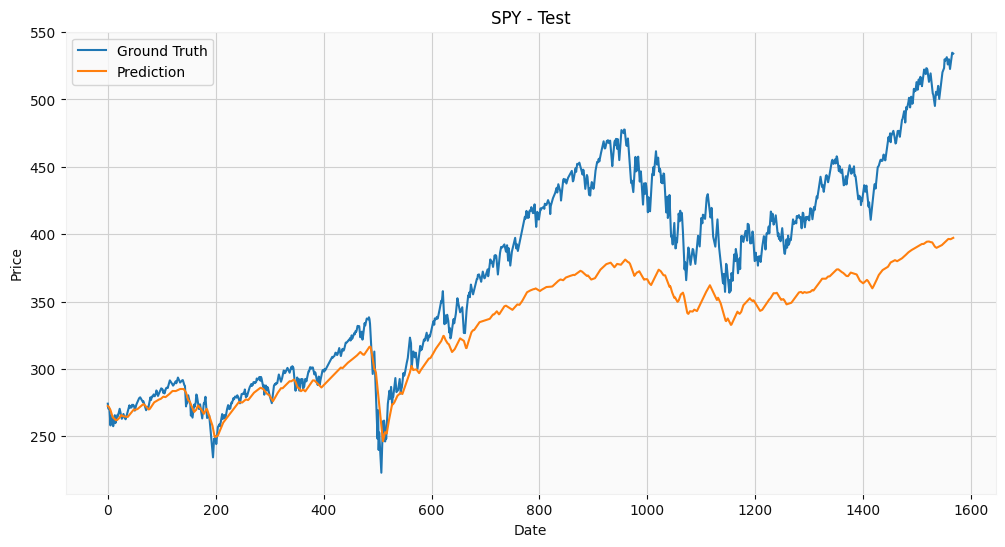

In [11]:
print(y_test_pred[-1][0])

plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Ground Truth')
plt.plot(y_test_pred, label='Prediction')
plt.title('SPY - Test')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()